# Problem set 1, Asymmetric loss regression

Let's load the data and plot the training / val data.

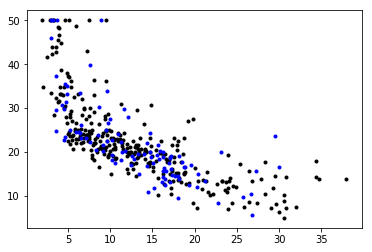

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Load data
dataTrain=np.loadtxt('housing-train.txt')
dataVal=np.loadtxt('housing-val.txt')

X_train=(dataTrain[:,np.newaxis,0])
y_train=dataTrain[:,1]
X_val=dataVal[:,np.newaxis,0]
y_val=dataVal[:,1]

plt.plot(X_train, y_train, 'k.')
plt.plot(X_val, y_val, 'b.')

np.s

First, we will solve the linear regression (under the "normal" symmetric squared loss) using the closed form solution. Let's define a couple of functions we will need.

In [41]:
def symmLoss(X, w ,y):
    """
    Get the symmetric squared loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    loss : a scalar
        The loss calculated by the symmetric loss formula
    """
    
    
    
    return np.sum( (y - np.dot(X,w) )**2 ) / len(y)

Note that the loss we have defined is the normalized squared loss

In [4]:
def lsqClosedForm(X, y):
    """
    Use closed form solution for least squares minimization

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    y : 1D array
        Observed function values

    Returns
    -------
    w : 1D array
        d+1 length vector
    """
    return np.dot(np.linalg.pinv(X), y)

Test the closed form solution: generate a toy data set from a random linear function with <b>no noise</b>. We should be able to perfectly recover w in this case (up to numerical precision).

In [5]:
np.random.seed(117)
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:  '+repr(w))
w_ = lsqClosedForm(X, y)
print('function output: '+repr(w_))
if (np.allclose(w,w_)):
    print('Close enough')
else:
    print('Uh-oh')

true weight:  array([ 0.02739388,  0.03030734])
function output: array([ 0.02739388,  0.03030734])
Close enough


The function to estimate the variance of the noise and the log likelihood of the data.

In [42]:
def logLikelihood(X, w, y):
    """
    Get the estimated variance, and the log likelihood of the data

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    simga2 : a scalar
        The estimated variance (sigma squared)
    loglike : a scalar
        The log-likelihood under the Gaussian noise model N(0,sigma2)
    """
    N = X.shape[0]   # number of rows in X
    
    # now estimate the variance of the Gaussian noise
    rss = symmLoss(X, w, y)
    n = len(y)
    sigma2 = rss * n / (n - len(w))
    
    # normalized log-likelihood (mean of per-data point log-likelihood of the model given by w,sigma2)
    const = - np.log( np.sqrt(2 * sigma2 * np.pi) ) 
    loglike =  - rss * n / (n * 2 * sigma2)
    
    return sigma2, loglike

Now let's fit linear, quadratic and cubic models to the training data, and plot the fit function. First we need to define the function that will map the original input to an expanded feature vector (including the constant term).

In [43]:
def degexpand(X, deg, C=None):
    """
    Prepares data matrix with a column of ones and polynomials of specified
    degree.

    Parameters
    ----------
    X : 2D array
        n x d data matrix (row per example)
    deg : integer
        Degree of polynomial
    C : 1D array
        Scaling weights. If not specifed, weights are calculated to fit each
        columns of X in [-1, 1].
        Note: It is shown in problem set 1 that this normalization does
        not affect linear regression, as long as it is applied
        consistently to training *and* test data.

    Returns
    -------
    out_X : 2D array
        n x (2 * d + 1) data matrix (row per example)
        The output is arranged as follows:
            - X[:, 0] is all ones
            - X[:, 1] is x_1
            - X[:, 2] is x_1^2
            - ...
            - X[:, deg] is x_1^deg
            - X[:, deg+1] is x_2
            - X[:, deg+2] is x_2^2
            - etc.
    C : 1D array
        Scaling weights that were used. Can be used in scaling other data later in the same way.
    """
    assert X.ndim == 2
    n, m = X.shape

    # Make polynomials
    out_X = (X[..., np.newaxis] ** (1. + np.arange(deg))).reshape(n, -1)

    # Add column of ones
    out_X = np.concatenate([np.ones((out_X.shape[0], 1)), out_X], axis=1)

    if C is None:
        C = abs(out_X).max(axis=0)
    else:
        assert np.shape(C) == (out_X.shape[1],), "C must match outgoing matrix"

    out_X /= C # divide dimension-wise
    return out_X, C


We can now fit models to the training data.

degree 1:
train loss 40.092548
val loss 40.234920
sigma^2: 40.358062 
log-likelihood -0.496711

degree 2:
train loss 31.626032
val loss 31.727872
sigma^2: 31.941242 
log-likelihood -0.495066

degree 3:
train loss 30.350771
val loss 31.246330
sigma^2: 30.755448 
log-likelihood -0.493421

degree 5:
train loss 27.407330
val loss 31.274918
sigma^2: 27.959156 
log-likelihood -0.490132



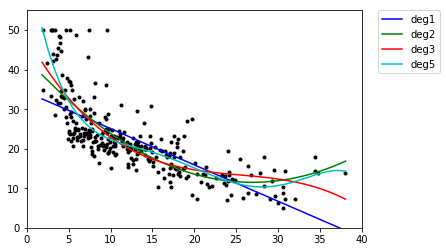

In [44]:
min_loss = np.Inf
plt.plot(X_train, y_train, 'k.')

#list to store best parameters 
best_param = [ None ] * 3 
best_loss = np.infty 
# Try different polynomial degrees
for deg in [1,2,3,5]:
    # Expand data first; you can check how this function works in utils.py
    X, C = degexpand(X_train, deg)
    y = y_train
    
    # Get the result by applying closed-form equation
    w = lsqClosedForm(X, y)
    
    # compute loss on training set
    loss = symmLoss(X, w, y)
    
    # compute loss on val set; note -- use the same scaling matrix C as for training
    val_loss = symmLoss(degexpand(X_val, deg, C)[0], w, y_val)
    
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f' %(val_loss))
    print('sigma^2: %.6f \nlog-likelihood %.6f\n' %logLikelihood(X, w, y))
    
    #********************** insert code to keep track of the best model so far
    
    if val_loss < best_loss: 
        best_param[0] = w
        best_param[1] = deg
        best_param[2] = C
        best_loss = val_loss
    
    # write the code above so that best_param[0] = w of the best model, 
    #                              best_param[1]=deg of the best model, 
    #                              best_param[2]=C (scaling matrix) of the best model
    
    # Plot the function
    color = {1:'b', 2:'g', 3:'r', 5:'c'}[deg]
    plt.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color,label='deg'+str(deg))

    
                             
    
axes = plt.gca()
axes.set_xlim([0,40])
axes.set_ylim([0,55])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [45]:
# Announce result of best selected model on validation data

dataTest=np.loadtxt('housing-val.txt')
print("Best degree:"+repr(best_param[1])+", loss (sym) on val:")
print(symmLoss(degexpand(X_val, best_param[1], best_param[2])[0], best_param[0], y_val))

Best degree:3, loss (sym) on val:
31.2463301689


(explain your logic for selecting the model)

To avoid overfitting, we use the loss on the validation set and not the training set. We take the model that gives the lowest validation loss. This is the model with polynomial degree 3. 

Now we want to repeat the experiment above but under the asymmetric loss function. Since there is no closed form solution, we will need to rely on gradient descent. First we need to implement the loss function, including the option of calculating the gradient of loss with respect to model parameters

In [102]:
def asymmLoss(X, w, y,alpha,_grad=False):
    """
    Get the asymmetric loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values
    alpha : scalar
        indicating multiplicative factor on underprediction loss (when prediction is lower than ground truth)
    _grad : boolean
        if True, compute and return gradient of the loss w.r.t. w on the data

    Returns
    -------
    loss : a scalar
        The loss calculated by equation in problem set 1
    grad : 1D array  (only when _grad == True)
        vector of same dimension as w, containing the gradient of loss w.r.t. w
    """
       
    #********** enter your code -- you should be able to largely replicate code in symmLoss, 
    #********** with some modifications to account for alpha
    
    residuals = y - np.dot(X,w) 
    alphas = [] #vector of weights (each element either 1 or alpha)
    weighted = [] #vector multiplation between the squared residuals and alphas 
    for r in residuals:  
        if r > 0: #underestimated 
            alphas.append(alpha)
        else: 
            alphas.append(1)     
    #print(residuals)
    #print(alphas)
    alphas = np.array(alphas)
    weighted = alphas * ( residuals **2) 
    loss = np.mean(weighted) 

    if _grad:
        grad = -2 * np.dot( alphas * residuals / len(y), X ) 
        return loss, grad 
    else:
        return loss
    

Test the loss and gradient function.

In [103]:
loss, grad = asymmLoss(np.array([[1,2], [1, -3]]), np.array([1,1]), np.array([4, -4]),10,_grad=True)
print("expected output")
print("7.0")
print("[ -8 -26]")
print("function output:")
print(loss)
print(grad)


expected output
7.0
[ -8 -26]
function output:
7.0
[ -8. -26.]


Since we have had the functions to calculate loss and gradient, we can implement the gradient descent algorithm.

In [104]:
def gradDescent(X, y,alpha,tol=1e-4,maxIt=10000,checkit=1000,verbose=2,lr=0.1):
    """
    Use gradient descent to min(loss(X, w, y))

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    y : 1D array
        Observed function values
    alpha : scalar
        weight on positive errors in asymmetric loss
    tol : scalar
        tolerance on loss decrease (default 1e-4)
    maxIt : scalar
        max allowed number of iterations (default 10000)
    checkit : scalar
        # of iterations after which the progress is checked for convergence
    verbose : scalar
        0  -- no progress report; 1 -- every checkit*10; 2 -- every checkit (default 2)
    lr : scalar
        learning rate (default 0.1)

    Returns
    -------
    w : 1D array
        d+1 length vector
        
    it: number of iterations until convergence
    """
    # Random initialize the weight
    w = np.random.randn(X.shape[1])
    it = 0
    lastloss = np.Inf
    while True:
        it += 1 # advance iteration count
        loss, grad = asymmLoss(X, w, y,alpha,_grad=True) # evaluate loss and compute gradient
        
        if it % checkit == 0:
            converged = it >= maxIt or loss > lastloss-tol
            lastloss = loss
            if verbose==2 or verbose==1 and it % (10*checkit) == 0:
                print('iter %d:  loss %.4f' %(it,loss))
            if converged:
                break
            
        w = w - lr * grad # update w (only if continuing updates)
       
        
    return w, it

Test gradient descent using any alpha and data generated by (random) noiseless linear model; we should recover the true w accurately (although possibly with less accuracy than the closed form solution for alpha=1)

In [105]:
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:'+repr(w))
w_, it_ = gradDescent(X, y,10,maxIt=10000,tol=1e-6)
print('%d iterations' %it_)
print('function output:'+repr(w_))

true weight:array([ 0.69527719,  0.85730512])
iter 1000:  loss 0.0000
iter 2000:  loss 0.0000
2000 iterations
function output:array([ 0.69527719,  0.85730512])


Now we can start testing the preformance of models using aymmetric loss.

degree 1:
train loss 3.884467
val loss 3.850933

iter 10000:  loss 3.3922
degree 2:
train loss 3.391044
val loss 3.400251

iter 10000:  loss 3.4316
iter 20000:  loss 3.4190
iter 30000:  loss 3.4083
iter 40000:  loss 3.3993
iter 50000:  loss 3.3916
degree 3:
train loss 3.391640
val loss 3.399512

iter 10000:  loss 3.4428
iter 20000:  loss 3.4130
iter 30000:  loss 3.4003
iter 40000:  loss 3.3928
iter 50000:  loss 3.3870
degree 5:
train loss 3.386972
val loss 3.411227



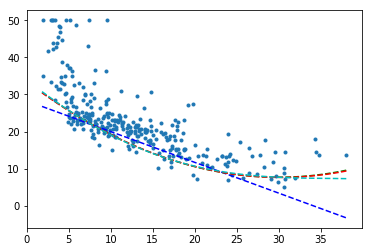

In [111]:
min_loss = np.Inf

plt.plot(X_train, y_train, '.')

alpha=.05;  # as specified in the problem set


best_param_asym = [None] * 3
best_loss = np.infty

for deg in[1,2,3,5]:
    # Expand data first
    X, C = degexpand(X_train, deg)
    y = y_train
        
    # Run gradient descent
    w, _ = gradDescent(X, y,alpha,maxIt=50000,checkit=1000,verbose=1,lr=1)
    loss = asymmLoss(X, w, y,alpha)
    val_loss = asymmLoss(degexpand(X_val, deg, C)[0], w, y_val,alpha)
    
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f\n' %(val_loss))
    
    #************** code for selecting best model
    # your code should store best_param_asym in the same format as for the symmetric loss experiments above
    if val_loss < best_loss: 
        best_param_asym[0] = w
        best_param_asym[1] = deg
        best_param_asym[2] = C
        best_loss = val_loss
    
    # Plot the function
    color = {1:'b', 2:'g', 3:'r', 5:'c'}[deg]
    plt.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color + '--')
    


In [112]:
# Announce result on validation data

dataTest=np.loadtxt('housing-val.txt')
print("Best degree:"+repr(best_param[1])+", loss (asym) on val:")
print(asymmLoss(degexpand(X_val, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_val,alpha))

Best degree:3, loss (asym) on val:
3.39951201096


In [113]:
# Now measure results on test with asymmetric loss, for both models (one learned with sym loss and one learned with asym loss)

dataTest=np.loadtxt('housing-test.txt')
X_test=(dataTest[:,np.newaxis,0])
y_test=dataTest[:,1]

print("Best degree (sym):"+repr(best_param[1]))
print('Asym loss: %.4f' %asymmLoss(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test,alpha))
print('Sym loss: %.4f' %symmLoss(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test))
print('Log-likelihood (symmetric): %.4f\n' %logLikelihood(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test)[1])


print("Best degree (asym):"+repr(best_param_asym[1]))
print('Asym loss: %.4f' %asymmLoss(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test,alpha))
print('Sym loss: %.4f' %symmLoss(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test))
print('Log-likelihood (symmetric): %.4f\n' %logLikelihood(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test)[1])



Best degree (sym):3
Asym loss: 10.9697
Sym loss: 22.1586
Log-likelihood (symmetric): -0.4802

Best degree (asym):3
Asym loss: 3.7299
Sym loss: 48.7512
Log-likelihood (symmetric): -0.4802



We are done with the experiments. Here you should write clearly and succinctly what your conclusions are: what model is better? Why? In what sense? See problem set for more instructions.